In [ ]:
# Install Kaggle CLI
!pip install -q kaggle


In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Download the mango leaf disease dataset
!kaggle datasets download -d aryashah2k/mango-leaf-disease-dataset
!unzip -q mango-leaf-disease-dataset.zip -d mango_leaf_disease

Dataset URL: https://www.kaggle.com/datasets/aryashah2k/mango-leaf-disease-dataset
License(s): Attribution-NonCommercial 4.0 International (CC BY-NC 4.0)


Preprocessing

In [ ]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Preprocessing pipeline
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# Load dataset
dataset_path = "/content/mango_leaf_disease"
data = datasets.ImageFolder(root=dataset_path, transform=transform)
dataloader = DataLoader(data, batch_size=64, shuffle=True)

# Check class names
print("Classes:", data.classes)


Classes: ['Anthracnose', 'Bacterial Canker', 'Cutting Weevil', 'Die Back', 'Gall Midge', 'Healthy', 'Powdery Mildew', 'Sooty Mould']


Variational Autoencoder (VAE)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(3 * 64 * 64, 512)
        self.fc21 = nn.Linear(512, 20)  # mean
        self.fc22 = nn.Linear(512, 20)  # logvar
        self.fc3 = nn.Linear(20, 512)
        self.fc4 = nn.Linear(512, 3 * 64 * 64)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparam(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.tanh(self.fc4(h3))  # <-- ensure range [-1, 1]


    def forward(self, x):
        x = x.view(-1, 3 * 64 * 64)
        mu, logvar = self.encode(x)
        z = self.reparam(mu, logvar)
        return self.decode(z), mu, logvar

# VAE loss
def vae_loss(recon_x, x, mu, logvar):
    BCE = F.mse_loss(recon_x, x.view(-1, 3 * 64 * 64), reduction='sum')
    logvar = torch.clamp(logvar, min=-10, max=10)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD


Train VAE

In [ ]:
vae = VAE().cuda()
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-4)

epochs = 20
for epoch in range(epochs):
    vae.train()
    train_loss = 0
    for batch, _ in dataloader:
        batch = batch.cuda()
        recon_batch, mu, logvar = vae(batch)
        loss = vae_loss(recon_batch, batch, mu, logvar)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    print(f'Epoch {epoch+1}, Loss: {train_loss / len(data)}')


Epoch 1, Loss: 2590.2033046875
Epoch 2, Loss: 1539.1202607421876
Epoch 3, Loss: 1101.3126572265626
Epoch 4, Loss: 919.7317456054687
Epoch 5, Loss: 844.2486376953125
Epoch 6, Loss: 778.1960849609375
Epoch 7, Loss: 719.29844140625
Epoch 8, Loss: 669.534005859375
Epoch 9, Loss: 632.0465810546875
Epoch 10, Loss: 602.9741748046876
Epoch 11, Loss: 579.5850380859375
Epoch 12, Loss: 561.123697265625
Epoch 13, Loss: 545.3392202148437
Epoch 14, Loss: 531.8951000976563
Epoch 15, Loss: 520.5433413085938
Epoch 16, Loss: 511.654619140625
Epoch 17, Loss: 502.4678049316406
Epoch 18, Loss: 494.7980595703125
Epoch 19, Loss: 488.7778742675781
Epoch 20, Loss: 483.192216796875


 Generate Synthetic Images (VAE)

In [ ]:
import torchvision

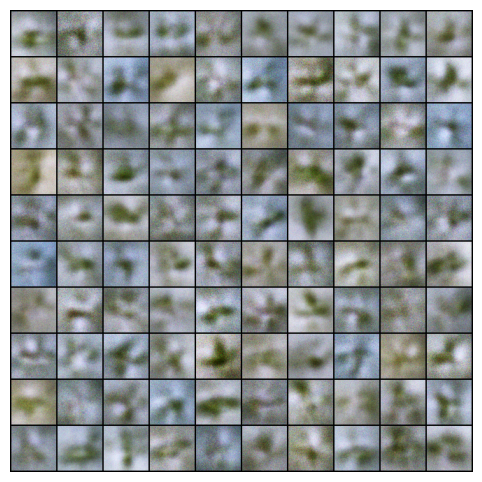

In [ ]:
import matplotlib.pyplot as plt

vae.eval()
with torch.no_grad():
    z = torch.randn(100, 20).cuda()
    samples = vae.decode(z).cpu().view(-1, 3, 64, 64)

def show_images(images, nrow=10):
    grid = torchvision.utils.make_grid(images, nrow=nrow, normalize=True)
    plt.figure(figsize=(12, 6))
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis("off")
    plt.show()

show_images(samples)


DCGAN Architecture

In [ ]:
import torch.nn as nn

# Generator
class Generator(nn.Module):
    def __init__(self, nz=100):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, 512, 4, 1, 0, bias=False),   # 1x1 → 4x4
            nn.BatchNorm2d(512),
            nn.ReLU(True),

            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),  # 4x4 → 8x8
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),  # 8x8 → 16x16
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),   # 16x16 → 32x32
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),     # 32x32 → 64x64
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),      # 64x64 → 32x32
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, 4, 2, 1, bias=False),     # 32x32 → 16x16
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, 4, 2, 1, bias=False),    # 16x16 → 8x8
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, 4, 2, 1, bias=False),    # 8x8 → 4x4
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(512, 1, 4, 1, 0, bias=False),      # 4x4 → 1x1
            nn.Sigmoid()
        )

    def forward(self, input):
        output = self.main(input)
        return output.view(-1)  # now output shape is (batch_size,)


 Train DCGAN

In [ ]:
netG = Generator().cuda()
netD = Discriminator().cuda()

criterion = nn.BCELoss()
optimizerD = torch.optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))

fixed_noise = torch.randn(100, 100, 1, 1).cuda()
nz = 100
epochs = 25

for epoch in range(epochs):
    for i, (real_images, _) in enumerate(dataloader):
        batch_size = real_images.size(0)
        real_images = real_images.cuda()

        # Real and fake labels
        real_labels = torch.ones(batch_size).cuda()
        fake_labels = torch.zeros(batch_size).cuda()

        # Train Discriminator
        netD.zero_grad()
        output = netD(real_images)
        loss_real = criterion(output, real_labels)

        noise = torch.randn(batch_size, nz, 1, 1).cuda()
        fake_images = netG(noise)
        output = netD(fake_images.detach())
        loss_fake = criterion(output, fake_labels)

        loss_D = loss_real + loss_fake
        loss_D.backward()
        optimizerD.step()

        # Train Generator
        netG.zero_grad()
        output = netD(fake_images)
        loss_G = criterion(output, real_labels)
        loss_G.backward()
        optimizerG.step()

    print(f"Epoch [{epoch+1}/{epochs}]  Loss_D: {loss_D.item():.4f}  Loss_G: {loss_G.item():.4f}")


Epoch [1/25]  Loss_D: 0.0036  Loss_G: 10.1537
Epoch [2/25]  Loss_D: 0.6032  Loss_G: 2.7922
Epoch [3/25]  Loss_D: 0.8589  Loss_G: 1.8416
Epoch [4/25]  Loss_D: 0.2787  Loss_G: 4.0247
Epoch [5/25]  Loss_D: 0.3812  Loss_G: 4.4112
Epoch [6/25]  Loss_D: 0.3775  Loss_G: 3.1092
Epoch [7/25]  Loss_D: 0.6311  Loss_G: 1.5567
Epoch [8/25]  Loss_D: 0.3829  Loss_G: 2.6238
Epoch [9/25]  Loss_D: 1.9256  Loss_G: 0.7983
Epoch [10/25]  Loss_D: 0.7734  Loss_G: 1.7118
Epoch [11/25]  Loss_D: 0.8197  Loss_G: 4.9663
Epoch [12/25]  Loss_D: 0.9002  Loss_G: 4.4390
Epoch [13/25]  Loss_D: 0.4306  Loss_G: 1.9457
Epoch [14/25]  Loss_D: 0.5402  Loss_G: 3.3016
Epoch [15/25]  Loss_D: 0.1587  Loss_G: 3.3552
Epoch [16/25]  Loss_D: 0.4021  Loss_G: 2.5950
Epoch [17/25]  Loss_D: 0.2747  Loss_G: 2.9092
Epoch [18/25]  Loss_D: 0.3813  Loss_G: 3.0579
Epoch [19/25]  Loss_D: 0.6888  Loss_G: 2.0568
Epoch [20/25]  Loss_D: 0.2110  Loss_G: 3.7773
Epoch [21/25]  Loss_D: 0.0744  Loss_G: 4.0703
Epoch [22/25]  Loss_D: 0.2924  Loss_G: 3.4

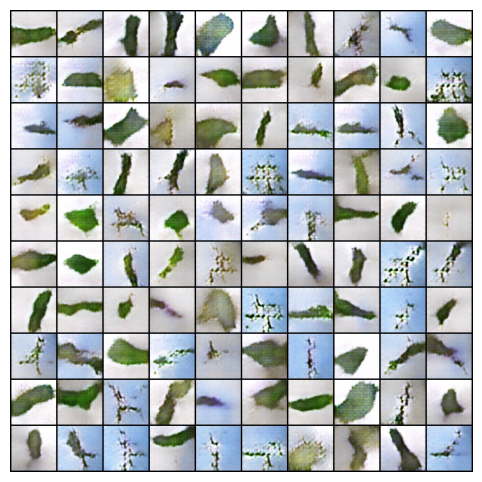

In [11]:
netG.eval()
with torch.no_grad():
    fake_imgs = netG(fixed_noise).cpu()

show_images(fake_imgs, nrow=10)


Evaluation

In [12]:
import os
from skimage.metrics import structural_similarity as ssim
from torchvision.utils import save_image
import torchvision.transforms.functional as TF
import numpy as np
from PIL import Image

# Create folders to save generated images
os.makedirs("vae_samples", exist_ok=True)
os.makedirs("gan_samples", exist_ok=True)
os.makedirs("real_samples", exist_ok=True)


In [13]:
# Save 100 real images
for i, (img, _) in enumerate(dataloader):
    if i * 64 >= 100: break
    for j in range(img.size(0)):
        if i * 64 + j >= 100: break
        save_image(img[j], f"real_samples/{i*64+j}.png", normalize=True)

# Generate and save 100 VAE images
vae.eval()
with torch.no_grad():
    z = torch.randn(100, 20).cuda()
    samples = vae.decode(z).cpu().view(-1, 3, 64, 64)
    for i in range(100):
        save_image(samples[i], f"vae_samples/{i}.png", normalize=True)

# Generate and save 100 GAN images
netG.eval()
with torch.no_grad():
    noise = torch.randn(100, 100, 1, 1).cuda()
    gan_imgs = netG(noise).cpu()
    for i in range(100):
        save_image(gan_imgs[i], f"gan_samples/{i}.png", normalize=True)


In [14]:
def compute_ssim(folder1, folder2):
    ssim_scores = []
    for i in range(100):
        img1 = Image.open(f"{folder1}/{i}.png").convert("RGB").resize((64, 64))
        img2 = Image.open(f"{folder2}/{i}.png").convert("RGB").resize((64, 64))
        img1_np = np.array(img1)
        img2_np = np.array(img2)
        score = ssim(img1_np, img2_np, channel_axis=2)
        ssim_scores.append(score)
    return np.mean(ssim_scores)

vae_ssim = compute_ssim("real_samples", "vae_samples")
gan_ssim = compute_ssim("real_samples", "gan_samples")

print(f"VAE SSIM Score: {vae_ssim:.4f}")
print(f"GAN SSIM Score: {gan_ssim:.4f}")


VAE SSIM Score: 0.1050
GAN SSIM Score: 0.3021


In [17]:
!pip install pytorch-fid

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 107.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 84.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 85.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [18]:
# Compute FID using pytorch-fid
!python -m pytorch_fid real_samples vae_samples --device cuda
!python -m pytorch_fid real_samples gan_samples --device cuda


Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
100% 91.2M/91.2M [00:00<00:00, 186MB/s]
100% 2/2 [00:01<00:00,  1.96it/s]
100% 2/2 [00:00<00:00,  3.99it/s]
FID:  373.38202819742975
100% 2/2 [00:00<00:00,  2.66it/s]
100% 2/2 [00:00<00:00,  3.92it/s]
FID:  271.9706859875513


In [15]:
import shutil

# Zip the sample folders
shutil.make_archive("real_samples", 'zip', "real_samples")
shutil.make_archive("vae_samples", 'zip', "vae_samples")
shutil.make_archive("gan_samples", 'zip', "gan_samples")



'/content/gan_samples.zip'

In [16]:
from google.colab import files

# Download to local machine
files.download("real_samples.zip")

files.download("gan_samples.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download("vae_samples.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Save VAE model
torch.save(vae.state_dict(), "vae_model.pth")

# Save GAN Generator model
torch.save(netG.state_dict(), "gan_generator.pth")


In [ ]:
from google.colab import files

# Download VAE and GAN Generator models
files.download("vae_model.pth")
files.download("gan_generator.pth")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>